In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns

In [2]:
censo_url  = 'https://raw.githubusercontent.com/guillermodangelo/tesis/master/tablas/personas_censo_2011.zip'
metadatos_figs = {'Author': '''Guillermo D'Angelo''',
                  'Title': 'Pirámide de población Censo INE 2011'}

In [3]:
# levanta datos censales
censo = pd.read_csv(censo_url, compression='zip', header=0, sep=',', quotechar='"')

In [4]:
censo.head(2)

,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERNA02,PERMI01,PERMI01_1,PERMI01_2,...,PERMI06,PERMI06_1,PERMI06_2,PERMI06_3,PERMI06_4,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4
0,1,20,1,1,2,22,1988-11-01,1,NaN,NaN,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0
1,1,20,1,1,2,84,1927-07-01,1,NaN,NaN,...,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0


In [5]:
# genera lista con cortes, para reclasificar el dataframe
bins = [0 if i==-1 else i for i in range(-1,95,5)]

print(len(bins))

# genera etiquetas con los tramos de edad usuales
l1 = [str(i) if i==0 else str(i+1) for i in bins][:19]
l2 = [str(i) for i in bins][1:]
labels = ['-'.join([l1[i], l2[i]]) for i in range(19)]
labels.append('+95')

print(len(labels))

# calcula tramos de edad
censo['tramo'] = pd.cut(censo['PERNA01'], bins= bins, include_lowest=False, labels=labels[:19])
censo['tramo'] = np.where(censo['PERNA01'] > 94 ,'95+', censo['tramo'])

# define vector de nombres de columnas para filtrar
cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERPH02', 'PERNA01', 'PERMI07',
        'PERMI07_1', 'PERMI07_2', 'PERMI07_3', 'PERMI07_4', 'tramo']

# filtra
p_migr = censo[(censo.PERMI07 == 2) | (censo.PERMI07 == 3)][cols]

p_migr.head()

20
20


,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERMI07,PERMI07_1,PERMI07_2,PERMI07_3,PERMI07_4,tramo
5,1,20,1,1,1,24,3,NaN,3.0,732.0,0,20-24
40,1,20,1,1,2,22,3,NaN,17.0,220.0,0,20-24
50,1,20,1,1,1,19,3,NaN,18.0,220.0,0,15-19
64,1,20,1,1,1,24,3,NaN,2.0,220.0,0,20-24
110,1,20,1,1,2,28,3,NaN,12.0,320.0,0,25-29


In [6]:
def agrupar_df(df, col_tramo, col_sexo):
    """Esta función agrupa por tramos y edad a un pandas dataframe con datos del Censo 2011"""
    
    # agrupa
    df_group = df.groupby([col_sexo, col_tramo]).size().reset_index()
    
    # renombra vars
    df_group.rename(columns={col_sexo: 'sexo', 0:'personas'}, inplace=True)
    
    # calcula porcentajes
    df_group['porc_pers'] = (df_group.personas / df_group.personas.sum())*100
    
    # pasa varones a negativo para grafica a la izquierda del eje central
    df_group.loc[df_group.sexo == 1, 'personas'] = -df_group['personas']
    df_group.loc[df_group.sexo == 1, 'porc_pers'] = -df_group['porc_pers']
    
    # genera etiqueta del sexo
    df_group['sexo_label'] = np.where(df_group['sexo'] ==1, 'varones', 'mujeres')
    
    return df_group

In [7]:
# agrupa migrantes recientes
migrantes_group = agrupar_df(p_migr,'tramo', 'PERPH02')

# con todo el censo
censo_group = agrupar_df(censo,'tramo', 'PERPH02')

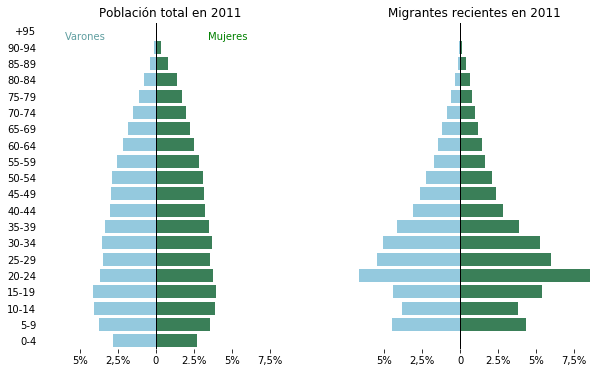

In [126]:
# pirámides de población

# cuatro ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= (10, 6), sharex= True, sharey='row')

# fig.subplots_adjust(wspace=0)

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, censo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)

ax1.set_title('Población total en 2011')
ax2.set_title('Migrantes recientes en 2011')

x_ticks_labels = ['7,5','5%','2,5%','0','2.5%','5%','7,5%']

for i in [ax1, ax2]:
    i.set_axisbelow(True)
    i.set_ylabel(None)
    i.set_xlabel(None)
    i.axvline(linewidth=1, color='black')
    i.set_xticklabels(x_ticks_labels)
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]
    
# chirimbolos
ax1.text(-6, 0.5, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax1.text(6, 0.5, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

plt.savefig('mapas_graficas/001_poblacion_vs_migrantes.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

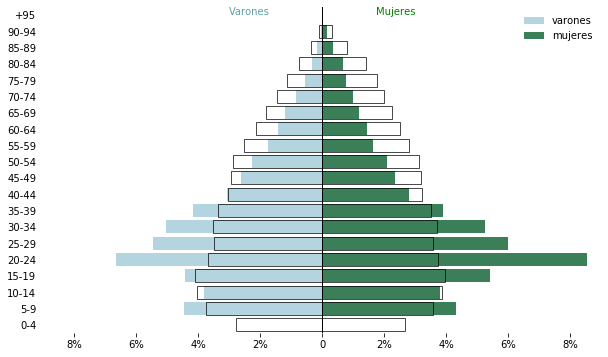

In [9]:
# pirámides de población solapadas
fig, ax  = plt.subplots(1, figsize= ( 10, 6 ))

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['lightblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=migrantes_group.loc[migrantes_group[group_col]==group, :],
                order = order_of_bars,
                color=c,
                label=group,
                ax=ax)

    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars,
                fill=False,
                linewidth = 0.7,
                edgecolor='black',
                ax=ax)

ax.set_axisbelow(True)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.axvline(linewidth=1, color='black')
ax.set_xlim([-9,9])
ax.set_xticklabels(['10%','8%','6%','4%','2%','0','2%','4%','6%','8%'])

[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_yticklines()]
    
ax.text(-3, 0, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax.text(3, 0, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

plt.savefig('mapas_graficas/002_piramide_mig.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

ax.legend(loc='upper right', frameon=False)

plt.show()

In [10]:
# migrantes recientes a Mvdeo. vs migrantes recientes a otros lados  
def agrupar_varios_df(df):
    """Aplica la funcion agrupa_df a 4 df"""
    df1 = df[df.DPTO==1]
    df2 = df[df.DPTO!=1]
    df3 = df[(df.DPTO != 1) & (df.PERMI07_2 != 1.0)]
    df4 = df[(df.DPTO!=1) & (df.PERMI07_2 == 1.0)]

    lista_df = [df1, df2, df3, df4]
    
    df_g = [agrupar_df(i,'tramo', 'PERPH02') for i in lista_df]
    
    return df_g[0], df_g[1], df_g[2], df_g[3]

mvo_group, int_group, int_no_mvo_group, int_si_mvo_group = agrupar_varios_df(p_migr)

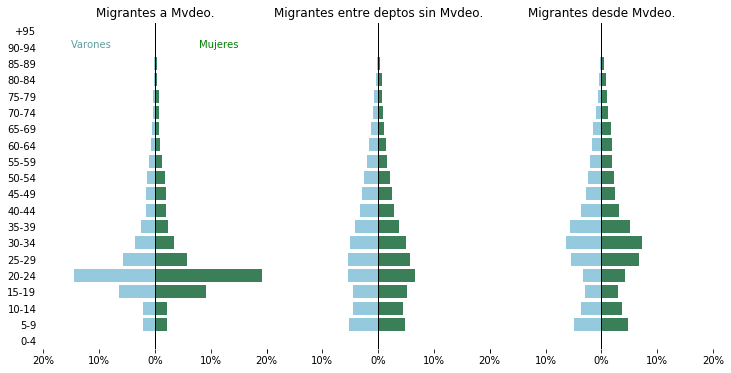

In [25]:
# pirámides de población
# tres ejes
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust( wspace=0)

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=mvo_group.loc[mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, int_no_mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=int_no_mvo_group.loc[int_no_mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)
    
for c, group in zip(colors, int_si_mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=int_si_mvo_group.loc[int_si_mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax3)

ax1.set_title('Migrantes a Mvdeo.')
ax2.set_title('Migrantes entre deptos sin Mvdeo.')
ax3.set_title('Migrantes desde Mvdeo.')

for i in [ax1, ax2, ax3]:
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    i.set_xlabel(None)
    i.set_ylabel(None)
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]

x_ticks_labels = ['20%','10%','0%','10%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels(['','10%','0%','10%',''])
ax3.set_xticklabels(x_ticks_labels)

ax1.text(-15, 1, 'Varones',
        horizontalalignment='left',
        color='cadetblue', fontsize=10)

ax1.text(15, 1, 'Mujeres',
        horizontalalignment='right',
        color='green', fontsize=10)

plt.savefig('mapas_graficas/003_piramides_mig_recientes.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

plt.show()

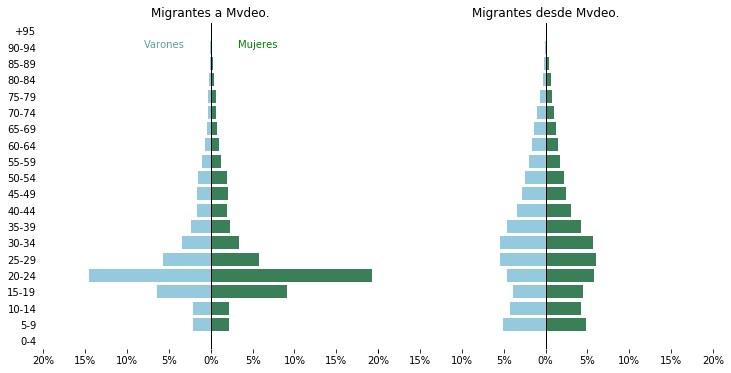

In [21]:
# pirámides de población

# dos ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust(wspace=0)

# plot
group_col = 'sexo_label'
order_of_bars = labels[::-1]
colors = ['skyblue', 'seagreen']
label=['sexo', 'sasa']

for c, group in zip(colors, mvo_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=mvo_group.loc[mvo_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax1)

for c, group in zip(colors, int_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=int_group.loc[int_group[group_col]==group, :],
                order = order_of_bars, color=c, label=group, ax=ax2)

ax1.set_title('Migrantes a Mvdeo.')
ax2.set_title('Migrantes desde Mvdeo.')

for i in [ax1, ax2]:
    i.set_ylabel(None)
    i.set_xlabel(None)
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]
    
x_ticks_labels = ['20%','15%','10%','5%','0%','5%','10%','15%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels([''] + x_ticks_labels[1:])

ax1.text(-8, 1, 'Varones',
         horizontalalignment='left',
         color='cadetblue', fontsize=10)

ax1.text(8, 1, 'Mujeres',
         horizontalalignment='right',
         color='green', fontsize=10)

plt.savefig('mapas_graficas/004_piramides_mig_recientes_desde_a_mvdeo.pdf',
             bbox_inches='tight',
             metadata= metadatos_figs )

plt.show()